# Effects of moving the locus along the genome

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [1]:
import os
import pickle
import cloudpickle
import itertools
import glob

# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import sys
sys.path.insert(0, '../../../')
import ccutils

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'retina'

tmpdir = '../../../tmp/'
figdir = '../../../fig/moment_dynamics_numeric/'
datadir = '../../../data/csv_maxEnt_dist/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{\eR}{\Delta\varepsilon_r}$
$\newcommand{\Nns}{N_{\text{NS}}}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{\ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\bb}[1]{\mathbf{#1}}$
$\newcommand{\dt}[1]{{\partial{#1} \over \partial t}}$
$\newcommand{\Km}{\bb{K}}$
$\newcommand{\Rm}{\bb{R}_m}$
$\newcommand{\Gm}{\bb{\Gamma}_m}$
$\newcommand{\Rp}{\bb{R}_p}$
$\newcommand{\Gp}{\bb{\Gamma}_p}$

## Problem setup

Vinu and Brewster have some super interesting data where they moved the location of the O1+11-YFP construct to different locus other than the usual *galK*. What they have found so far is that when they perform the usual *lacI* titration on these cells the binding energy $\eR$ comes out to be different to what we fit on the *galK* locus.

Now this is very intriguing since in principle Franz and Brewster used multiple loci and even promoters on plasmids for their 2014 cell paper and they still used the *galK* binding energy. Their current hypothesis is that if we were to cast this problem in the language of the chemical master equation it would be $\kron$ rather than $\kroff$ what changes. What this means is that the "accesibility" of the promoter varies as it is moved around the genome. I agree that this hypothesis is very reasonable since we know that the local environment of the genome changes due to things such as super coiling and other structural elements that affect the packing of the nucleoid.

### Proposed test

My proposal for this data set was that in our recent submision we were able to use the chemical master equation to predict not only the mean gene expression but the noise (std / mean) and even the full distribution. The key to get the noise right was to include the effect of having varying copy number of the gene depening on its position along the genome. So in principle if it is true that only $\kron$ rather than $\kroff$ change as the gene is moved around, we could potentially see these effects in the structure of the noise.

To test such idea we will start very simple. The first thing to do is to compare from our reference locus (*galK*) if we were to change the binding energy $\eR$ by some amount let's say $\delta \varepsilon_r$, could we distinguish if this was due to $\kron$ or $\kroff$?
For this we will be using functions that I wrote for the paper where the moment dynamics are integrated over time accounting for what fraction of the cell cycle is spent with one vs two copies.

Let's begin by setting the parameters for my growth conditions (100 min doubling time in deep 96 well plates)

In [3]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../../data/mcmc/lacUV5_constitutive_mRNA_double_expo.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Use the protein production rate defined to give 500 proteins per cell
rp = 0.0595

### Test functions with unregulated two-state promoter

Before jumping into the real matter let's test the functions. For this we will run the moment dynamics for the unregulated two-state promoter. We will import a `.pkl` file that contains the matrix defining the dynamics.

#### Setting initial conditions

Since for this model we are explicitly accounting for cell division I do not consider protein degradation as a Poission process. What that means is that I set the degradation rate $\gp = 0$. This means that the only source of "degradation" is due to dilution as the cells divide. 

But in order to set some initial conditions for all moments I want to start at a better guess that setting every value of $\ee{m^x p^y}$ to zero. So what I decided to do was to run the dynamics for a long time with a non-zero protein degradation rate $\gp$. If these dynamics were ran without accounting for the protein dilution the proteins would grow without bounds since there are no degradation. That is why I have to set an artificial degradation rate **only to set initial conditions**. Once the "real dynamics" are calculated, we go back to having only dilution due to growth as the only source of protein degradation.

Let's set these initial conditions then with the fake protein degradation.

In [4]:
# Single promoter
gp_init = 1 / (60 * 60)
rp_init = 500 * gp_init

# Read protein ununregulated matrix 
with open('../two_state_protein_dynamics_matrix.pkl', 'rb') as file:
    # Load sympy object containing the matrix A that define the
    # moment dynamics
    A_mat_unreg_lam = cloudpickle.load(file)
    # Load the list of moments included in the matrix
    expo = cloudpickle.load(file)
    
# Substitute value of parameters on matrix
##  Initial conditions
A_mat_unreg_s_init = A_mat_unreg_lam(kp_on, kp_off, rm, gm, rp_init, gp_init)

# Define time on which to perform integration
t = np.linspace(0, 4000 * 60, 2000)

# Define initial conditions
mom_init = np.zeros(len(expo) * 2)
# Set initial condition for zero moment
# Since this needs to add up to 1
mom_init[0] = 1

# Numerically integrate equations
mp_sol = sp.integrate.odeint(ccutils.model.dmomdt, mom_init, t, 
                             args=(A_mat_unreg_s_init,))

mp_init = mp_sol[-1, :]

print('<m> = {:.1f}'.format(mp_init[2:4].sum()))
print('<p> = {:.1f}'.format(mp_init[14:16].sum()))
print('<p>/<m> = {:.1f}'.format(mp_init[14:16].sum() / mp_init[2:4].sum()))

<m> = 12.0
<p> = 5982.3
<p>/<m> = 500.0


Excellent. So we ran these dynamics for a very long time and they reached the expected steady state of having 500 proteins per mRNA on average.

Now let's run the real dynamics accounting for the variability during the cell cycle.

In [5]:
# Define doubling time
doubling_time = 100
# Define fraction of cell cycle spent with one copy
t_single_frac = 0.6
# Define time for single-promoter state
t_single = 60 * t_single_frac * doubling_time # sec
t_double = 60 * (1 - t_single_frac) * doubling_time # sec

# Define number of cell cycles
n_cycles = 6

# Define list of parameters
par_single = [kp_on, kp_off, rm, gm, rp, 0]
par_double = [kp_on, kp_off, 2 * rm, gm, rp, 0]

# Integrate moment equations
df_p_unreg = ccutils.model.dmomdt_cycles(mp_init,
                           t_single, t_double, 
                           A_mat_unreg_lam, 
                           par_single, par_double, expo,
                           n_cycles, n_steps=10000)

# Extract index for mRNA and protein first moment
first_mom_names_m = [x for x in df_p_unreg.columns
                     if 'm1p0' in x]
first_mom_names_p = [x for x in df_p_unreg.columns
                     if 'm0p1' in x]

# Extract the last cycle information
df_m_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == df_p_unreg.cycle.max(),
                                  first_mom_names_m]
df_p_unreg_first = df_p_unreg.loc[df_p_unreg.cycle == df_p_unreg.cycle.max(),
                                  first_mom_names_p]

# Define array for integration
a_array = np.linspace(0, 1, len(df_m_unreg_first))
# Compute probability based on this array
p_a_array = np.log(2) * 2**(1 - a_array)

# Perform numerical integration
m_mean_unreg = sp.integrate.simps(df_m_unreg_first.sum(axis=1) * p_a_array,
                                  a_array)
p_mean_unreg = sp.integrate.simps(df_p_unreg_first.sum(axis=1) * p_a_array,
                                  a_array)

print('unregulated promoter:')
print('<m> = {:.2f}'.format(m_mean_unreg))
print('<p> = {:.2f}'.format(p_mean_unreg))
print('<p>/<m> = {:.1f}'.format(p_mean_unreg / m_mean_unreg))

unregulated promoter:
<m> = 16.49
<p> = 8243.24
<p>/<m> = 499.8


### Plotting time dynamics

Our protein production rate satisfies the expected condition. Now let's plot the mean mRNA and mean protein. For this we first need to extract all the first moments for each of the promoter states and add them together to get the global first moment.

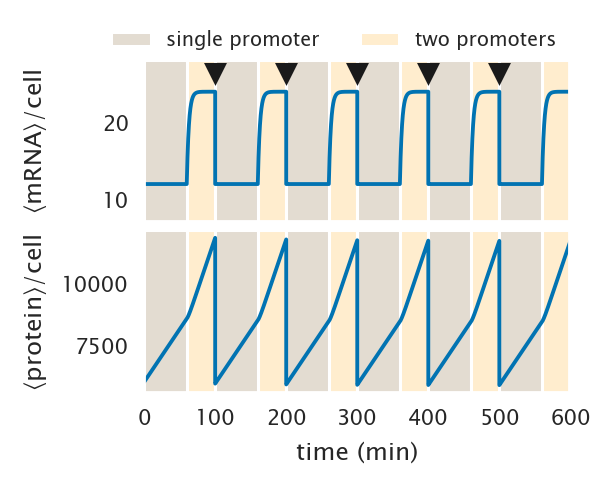

In [6]:
# Extract index for first moment
first_mom_names_m = [x for x in df_p_unreg.columns if 'm1p0' in x]
first_mom_names_p = [x for x in df_p_unreg.columns if 'm0p1' in x]

# Compute the mean mRNA copy number
m_mean = df_p_unreg.loc[:, first_mom_names_m].sum(axis=1)
p_mean = df_p_unreg.loc[:, first_mom_names_p].sum(axis=1)

# Initialize figure
fig, ax = plt.subplots(2, 1, figsize=(2.5, 2), sharex=True)

# Plot mean mRNA as solid line
ax[0].plot(df_p_unreg.time / 60, m_mean, label='', lw=1.25)
ax[1].plot(df_p_unreg.time / 60, p_mean, label='', lw=1.25)

# Group data frame by cell cycle
df_group = df_p_unreg.groupby('cycle')

# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Define the label only for the last cell cycle not to repeat in legend
    if group == df_p_unreg['cycle'].max():
        label_s = 'single promoter'
        label_d = 'two promoters'
    else:
        label_s = ''
        label_d = ''
    # Find index for one-promoter state
    idx = np.where(data.state == 'single')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60, 
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label=label_s)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60, 
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#e3dcd1', label='')
    
    # Find index for two-promoter state
    idx = np.where(data.state == 'double')[0]
    # Indicate states with two promoters
    ax[0].axvspan(data.iloc[idx.min()]['time'] / 60,
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label=label_d)
    ax[1].axvspan(data.iloc[idx.min()]['time'] / 60,
                  data.iloc[idx.max()]['time'] / 60,
               facecolor='#ffedce', label='')

##  Indicate where the cell divisions happen
# First find where the cell cycle transition happen
trans_idx = np.array(np.diff(df_p_unreg.cycle) == 1)
# Add extra point to have same length
trans_idx = np.insert(trans_idx, 0, False)  
# Get the time points at which this happens
time_div = df_p_unreg[trans_idx].time.values
# Plot with a triangle the cell division moment
ax[0].plot(time_div / 60, [np.max(m_mean) * 1.1] * len(time_div),
           lw=0, marker='v', color='k')

# Set limits
# mRNA
ax[0].set_xlim(df_p_unreg['time'].min() / 60, df_p_unreg['time'].max() / 60)
ax[0].set_ylim([7, 28])
#protein
ax[1].set_xlim(df_p_unreg['time'].min() / 60, df_p_unreg['time'].max() / 60)

# Label plot
ax[1].set_xlabel('time (min)')
ax[0].set_ylabel(r'$\left\langle \right.$mRNA$\left. \right\rangle$/cell')
ax[1].set_ylabel(r'$\left\langle \right.$protein$\left. \right\rangle$/cell')

# Align y axis labels
fig.align_ylabels()

# Set legend for both plots
ax[0].legend(loc='upper left', ncol=2, frameon=False,
             bbox_to_anchor=(-0.12, 0, 0, 1.3), fontsize=6.5)

plt.subplots_adjust(hspace=0.05)

Everything seems to be working as expected. Time to test the dynamics of regulated promoters.

### Regulated three-state promoter

First thing we need is to determine the parameters for the regulated promoter. Specifically we will define $N_{NS}$ the number of non-specific binding sites, the MWC parameters $K_A$, $K_I$ and $\Delta\varepsilon_{AI}$, and finally the default diffusion limited on rate $k_o$. This last parameter is the one that will change if $\kron$ is what is changing since we define this on rate as
$$
\kron = k_o [R].
$$
So if the on rate $\kron$ changes while the repressor copy number remains constant, it means that the diffusion limited on rate $k_o$ should be the parameter changing.

Let's define these parameters.

In [7]:
# Define repressor specific parameters

# Diffusion limited rate
ko = 2.7E-3 # s**-1 nmol**-1

# Number of non-specific binding sites in thermodynamic model
Nns = 4.6E6

# Cell volume
Vcell = 2.15 # fL

# MWC induction parameters
ka = 139 # µM
ki = 0.53 # µM
epsilon = 4.5 # kBT

We also need to import the `.pkl` object that contains the dynamics of the three-state promoter.

In [8]:
# Read protein ununregulated matrix 
with open('../three_state_protein_dynamics_matrix.pkl', 'rb') as file:
    A_mat_reg_lam = cloudpickle.load(file)
    expo_reg = cloudpickle.load(file)

### Computing moments for multiple parameters

We now have everything ready to compute the moments for different operators, repressor copy numbers and inducer concentrations. For this exercise we will first assume that everything is integrated into *galK* as usual. We will compute the moments for a series of energy offshifts ranging from -1.5 to 1.5 $k_BT$.

First let's define all of the different parameters that we will change

In [9]:
# Define experimental concentrations in µM
inducer = np.logspace(-1, np.log10(5000), 15) # µM
inducer = np.insert(inducer, 0, 0)

# Define repressor copy numebers
repressors = np.logspace(1, np.log10(2000), 15)
repressors = np.append([0], repressors)

# Define operators and energies
operators = ['O1', 'O2']
energies = [-15.3, -13.9]
op_dict = dict(zip(operators, energies))

# Define energy offshifts
energy_off = [-1.5, -1, -0.5, 0, 0.5, 1, 1.5]

# Generate list of all variables
var =  [t for t in itertools.product(*[operators, repressors,
                                       inducer, energy_off])]

Now let's run the computation in parallele for each individual set of parameters. We will assume that the energy offshift is due to $\kroff$ first.

In [13]:
# Boolean indicating if computation should be performed
compute_constraints = False

if compute_constraints:
    # Initialize data frame to save the lagrange multipliers.
    names = ['operator', 'binding_energy', 'offshift', 'repressor',
             'inducer_uM']
    names = names + ['m' + str(m[0]) + 'p' + str(m[1]) for m in expo_reg]
    
    # Initialize DataFrame to save constraints
    df_constraints = pd.DataFrame([], columns=names)

    # Define function for parallel computation
    def constraints_parallel(param):
        # Extract variables
        op = param[0]  #operator
        eRA = op_dict[op] + param[3]  # binding energy
        rep = param[1]  # repressors
        iptg = param[2]  # inducer
        
        print(op, eRA, rep, iptg)
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * ccutils.model.p_act(iptg, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = ccutils.model.kr_off_fun(eRA, ko, kp_on, kp_off,
                                          Nns, Vcell)

        # Generate matrices for dynamics
        # Single promoter
        par_reg_s = [kr_on, kr_off, kp_on, kp_off, rm, gm, rp, 0]
        # Two promoters
        par_reg_d = [kr_on, kr_off, kp_on, kp_off, 2 * rm, gm, rp, 0]
        
        # Initial conditions
        A_reg_s_init = A_mat_reg_lam(kr_on, kr_off, kp_on, kp_off,
                                     rm, gm, rp_init, gp_init)
        
        # Define initial conditions
        mom_init = np.zeros(len(expo_reg) * 3)
        # Set initial condition for zero moment
        # Since this needs to add up to 1
        mom_init[0] = 1

        # Define time on which to perform integration
        t = np.linspace(0, 4000 * 60, 10000)
        # Numerically integrate equations
        m_init = sp.integrate.odeint(ccutils.model.dmomdt, 
                                     mom_init, t, 
                                     args=(A_reg_s_init,))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]
        
        # Integrate moment equations
        df = ccutils.model.dmomdt_cycles(m_init, 
                                         t_single, t_double,
                                         A_mat_reg_lam, 
                                         par_reg_s, par_reg_d,
                                         expo_reg, n_cycles,
                                         states=['A', 'I', 'R'], 
                                         n_steps=3000)
        
        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Define array for integration
        a_array = np.linspace(0, 1, len(df))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Initialize list to append moments
        moms = list()
        # Loop through moments computing the average moment
        for i, mom in enumerate(expo_reg):
            # Generate string that finds the moment
            mom_name = 'm' + str(mom[0]) + 'p' + str(mom[1])
            # List rows with moment
            mom_bool = [x for x in df.columns if mom_name in x]
            # Extract data for this particular moment
            df_mom = df.loc[:, mom_bool].sum(axis=1)

            # Average moment and append it to list
            moms.append(sp.integrate.simps(df_mom * p_a_array,
                                           a_array))
                
        # Save results into series in order to append it to data frame
        series = pd.Series([op, eRA, param[3], rep, iptg] + moms,
                   index=names)
    
        return series
    
    # Run function in parallel
    constraint_series = Parallel(n_jobs=6)(delayed(constraints_parallel)(param)
                           for param in var)

    # Initialize data frame to save list of parameters
    df_constraints = pd.DataFrame([], columns=names)

    for s in constraint_series:
        df_constraints = df_constraints.append(s, ignore_index=True)

    # Save progress at each step
    df_constraints.to_csv(tmpdir + 'moments_kroff_change.csv',
              index=False)

df_kroff = pd.read_csv(tmpdir + 'moments_kroff_change.csv')
df_kroff.head()

,operator,binding_energy,offshift,repressor,inducer_uM,m0p0,m1p0,m2p0,m3p0,m4p0,...,m3p2,m2p3,m1p4,m0p5,m5p1,m4p2,m3p3,m2p4,m1p5,m0p6
0,O1,-16.8,-1.5,0.0,0.0,1.000001,16.491037,365.583856,10216.956030,342393.491601,...,1.079538e+12,4.231228e+14,2.031885e+17,1.223482e+20,1.333070e+11,3.779069e+13,1.286712e+16,5.202613e+18,2.514082e+21,1.497718e+24
1,O1,-16.3,-1.0,0.0,0.0,1.000001,16.491037,365.583856,10216.956030,342393.491601,...,1.079538e+12,4.231228e+14,2.031885e+17,1.223482e+20,1.333070e+11,3.779069e+13,1.286712e+16,5.202613e+18,2.514082e+21,1.497718e+24
2,O1,-15.8,-0.5,0.0,0.0,1.000001,16.491039,365.583907,10216.957441,342393.538620,...,1.079538e+12,4.231228e+14,2.031885e+17,1.223482e+20,1.333070e+11,3.779070e+13,1.286712e+16,5.202613e+18,2.514081e+21,1.497717e+24
3,O1,-15.3,0.0,0.0,0.0,1.000001,16.491031,365.583733,10216.952641,342393.379432,...,1.079538e+12,4.231228e+14,2.031885e+17,1.223482e+20,1.333070e+11,3.779069e+13,1.286712e+16,5.202613e+18,2.514082e+21,1.497718e+24
4,O1,-14.8,0.5,0.0,0.0,1.000001,16.491042,365.583995,10216.960264,342393.642130,...,1.079538e+12,4.231228e+14,2.031885e+17,1.223482e+20,1.333070e+11,3.779070e+13,1.286712e+16,5.202613e+18,2.514082e+21,1.497717e+24


Excellent. Now we will repeat the exercise but this time following Brewster's hypothesis that it is $\kron$ what changes rather than $\kroff$. For this we need to recall that the fold-change in gene expression is given by
$$
\foldchange = \left( 1 + {\kron \over \kroff} \left( {\kpon \over \kpon + \kpoff} \right) \right)^{-1}.
$$

If we let $\kron \equiv k_o [R]$, where $k_o$ is a diffusion limited on rate and $[R]$ is the concentration of repressors, then it can be shown that for the thermodynamic picture and the kinetic picture to give the same answer it must be true that
$$
{k_o [R] \over \kroff}{\kpoff \over \kpoff + \kpon} =
{R \over \Nns} e^{- \beta \eR}.
$$
Since Jones \& Brewster reporteda  value for $k_o$ and we knew the repressor copy number for our cells the repressor off rate $\kroff$ was constrained as
$$
\kroff \approx 0.8 \cdot k_o \cdot \Nns e^{\beta \eR} 
\cdot {\kpoff \over \kpoff + \kpon},
$$
where the factor of 0.8 has to do with the conversion between absolute number of proten and concentration for the volume of our *E. coli* cells at the particular growth conditions of 2.1 fL.

If we now claim that it is $\kron$ what changes rather than $\kroff$ what I will do is determine $\kroff$ assuming the usual binding energy $\eR$, and thte usual diffusion limited on rate $k_o$. After that I will modify the diffusion limited on rate as
$$
k_o' = k_o \cdot e^{-\beta \Delta\eR},
$$
where $\Delta\eR$ is the change in the binding energy as determined in the experiment.

Let's go ahead and run this.

In [14]:
# Boolean indicating if computation should be performed
compute_constraints = False

if compute_constraints:
    # Initialize data frame to save the lagrange multipliers.
    names = ['operator', 'binding_energy', 'offshift', 'repressor',
             'inducer_uM']
    names = names + ['m' + str(m[0]) + 'p' + str(m[1]) for m in expo_reg]
    
    # Initialize DataFrame to save constraints
    df_constraints = pd.DataFrame([], columns=names)

    # Define function for parallel computation
    def constraints_parallel(param):
        # Extract variables
        op = param[0]  #operator
        eRA = op_dict[op]  # binding energy
        rep = param[1]  # repressors
        iptg = param[2]  # inducer
        
        print(op, eRA, rep, iptg)
        # Calculate the repressor on rate including the MWC model
        kr_on = ko * rep * ccutils.model.p_act(iptg, ka, ki, epsilon) 

        # Compute the repressor off-rate based on the on-rate and 
        # the binding energy
        kr_off = ccutils.model.kr_off_fun(eRA, ko, kp_on, kp_off,
                                          Nns, Vcell)

        # Update kr_on by changing the diffusion limited on rate
        kr_on = kr_on * np.exp(-param[3])
        
        # Generate matrices for dynamics
        # Single promoter
        par_reg_s = [kr_on, kr_off, kp_on, kp_off, rm, gm, rp, 0]
        # Two promoters
        par_reg_d = [kr_on, kr_off, kp_on, kp_off, 2 * rm, gm, rp, 0]
        
        # Initial conditions
        A_reg_s_init = A_mat_reg_lam(kr_on, kr_off, kp_on, kp_off,
                                     rm, gm, rp_init, gp_init)
        
        # Define initial conditions
        mom_init = np.zeros(len(expo_reg) * 3)
        # Set initial condition for zero moment
        # Since this needs to add up to 1
        mom_init[0] = 1

        # Define time on which to perform integration
        t = np.linspace(0, 4000 * 60, 10000)
        # Numerically integrate equations
        m_init = sp.integrate.odeint(ccutils.model.dmomdt, 
                                     mom_init, t, 
                                     args=(A_reg_s_init,))
        # Keep last time point as initial condition
        m_init = m_init[-1, :]
        
        # Integrate moment equations
        df = ccutils.model.dmomdt_cycles(m_init, 
                                         t_single, t_double,
                                         A_mat_reg_lam, 
                                         par_reg_s, par_reg_d,
                                         expo_reg, n_cycles,
                                         states=['A', 'I', 'R'], 
                                         n_steps=3000)
        
        # Keep only last cycle
        df = df[df['cycle'] == df['cycle'].max()]

        # Define array for integration
        a_array = np.linspace(0, 1, len(df))
        # Compute probability based on this array
        p_a_array = np.log(2) * 2**(1 - a_array)

        # Initialize list to append moments
        moms = list()
        # Loop through moments computing the average moment
        for i, mom in enumerate(expo_reg):
            # Generate string that finds the moment
            mom_name = 'm' + str(mom[0]) + 'p' + str(mom[1])
            # List rows with moment
            mom_bool = [x for x in df.columns if mom_name in x]
            # Extract data for this particular moment
            df_mom = df.loc[:, mom_bool].sum(axis=1)

            # Average moment and append it to list
            moms.append(sp.integrate.simps(df_mom * p_a_array,
                                           a_array))
                
        # Save results into series in order to append it to data frame
        series = pd.Series([op, eRA, param[3], rep, iptg] + moms,
                   index=names)
    
        return series
    
    # Run function in parallel
    constraint_series = Parallel(n_jobs=6)(delayed(constraints_parallel)(param)
                           for param in var)

    # Initialize data frame to save list of parameters
    df_constraints = pd.DataFrame([], columns=names)

    for s in constraint_series:
        df_constraints = df_constraints.append(s, ignore_index=True)

    # Save progress at each step
    df_constraints.to_csv(tmpdir + 'moments_kron_change.csv',
              index=False)

df_kron = pd.read_csv(tmpdir + 'moments_kron_change.csv')
df_kron.head()

,operator,binding_energy,offshift,repressor,inducer_uM,m0p0,m1p0,m2p0,m3p0,m4p0,...,m3p2,m2p3,m1p4,m0p5,m5p1,m4p2,m3p3,m2p4,m1p5,m0p6
0,O1,-15.3,-1.5,0.0,0.0,1.000001,16.491031,365.583733,10216.952641,342393.379432,...,1.079538e+12,4.231228e+14,2.031885e+17,1.223482e+20,1.333070e+11,3.779069e+13,1.286712e+16,5.202613e+18,2.514082e+21,1.497718e+24
1,O1,-15.3,-1.0,0.0,0.0,1.000001,16.491031,365.583733,10216.952641,342393.379432,...,1.079538e+12,4.231228e+14,2.031885e+17,1.223482e+20,1.333070e+11,3.779069e+13,1.286712e+16,5.202613e+18,2.514082e+21,1.497718e+24
2,O1,-15.3,-0.5,0.0,0.0,1.000001,16.491031,365.583733,10216.952641,342393.379432,...,1.079538e+12,4.231228e+14,2.031885e+17,1.223482e+20,1.333070e+11,3.779069e+13,1.286712e+16,5.202613e+18,2.514082e+21,1.497718e+24
3,O1,-15.3,0.0,0.0,0.0,1.000001,16.491031,365.583733,10216.952641,342393.379432,...,1.079538e+12,4.231228e+14,2.031885e+17,1.223482e+20,1.333070e+11,3.779069e+13,1.286712e+16,5.202613e+18,2.514082e+21,1.497718e+24
4,O1,-15.3,0.5,0.0,0.0,1.000001,16.491031,365.583733,10216.952641,342393.379432,...,1.079538e+12,4.231228e+14,2.031885e+17,1.223482e+20,1.333070e+11,3.779069e+13,1.286712e+16,5.202613e+18,2.514082e+21,1.497718e+24


### Comparing changes in $\kron$ vs $\kroff$ fold-change

Having computed the distribution moments let's compare the changes in the moments. First let's compute the fold-change at the protein level defined as 
$$
\foldchange = {\ee{p(R \neq 0)} \over \ee{p(R = 0)}}.
$$

We will first plot this for no inducer $c = 0$ as a function of the repressor copy number.

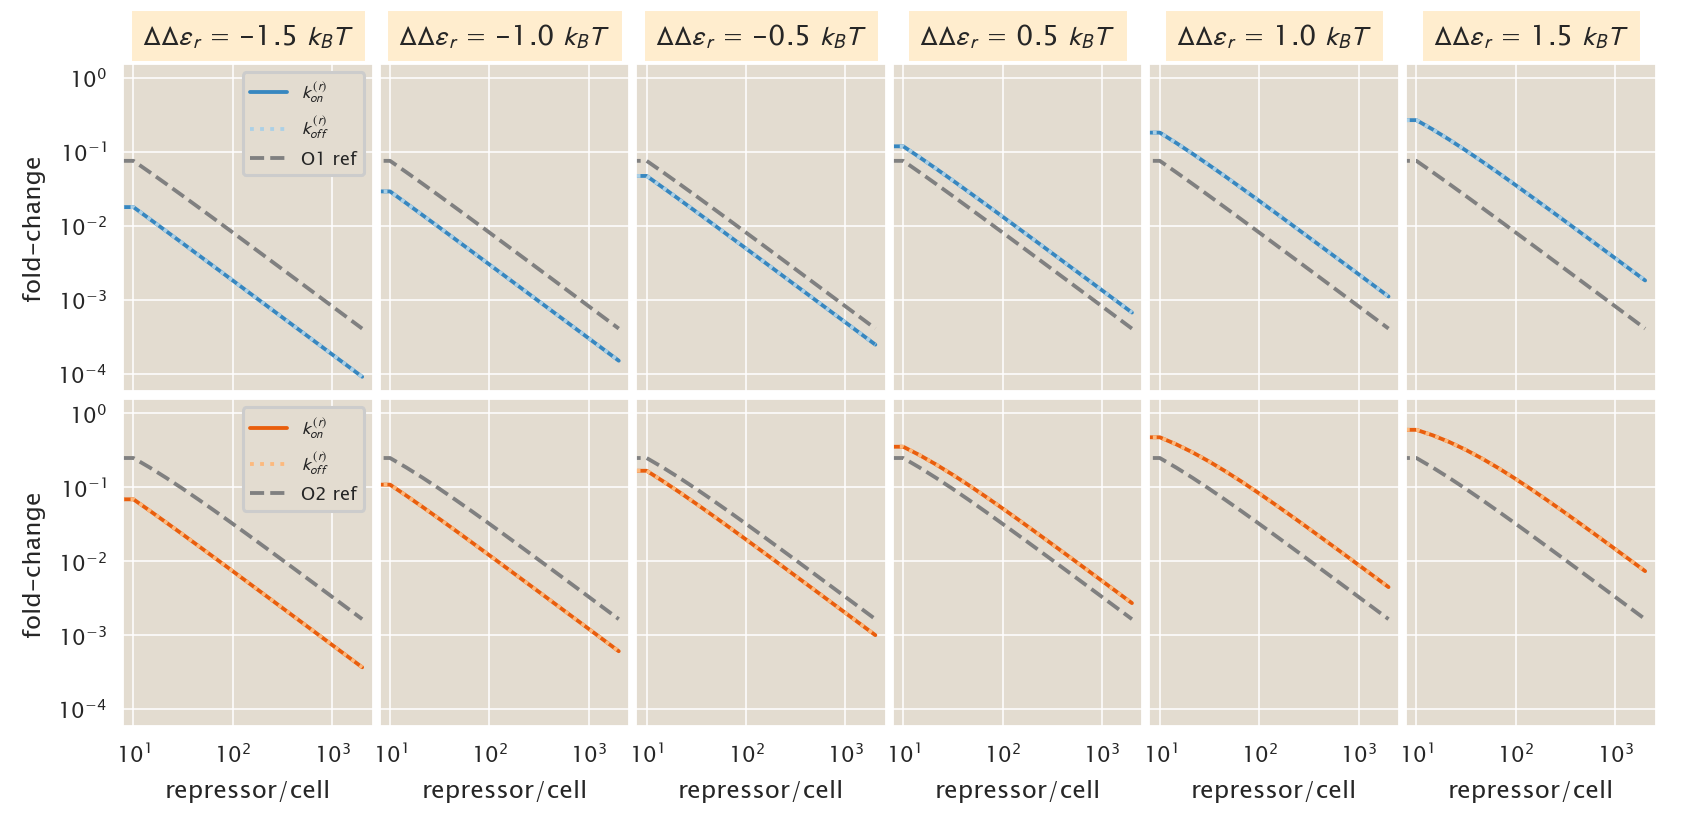

In [61]:
# Extract data with c = 0
df_kroff_c0 = df_kroff[df_kroff.inducer_uM == 0]
df_kron_c0 = df_kron[df_kron.inducer_uM == 0]

# List unique energy offshifts different from zero
offshift = df_kroff.offshift.unique()
offshift_unique = offshift[offshift != 0]

# Define color for operators
# Generate list of colors
col_list = ['Blues_r', 'Oranges_r']

# Initialize plot
fig, ax = plt.subplots(2, 6, figsize=(9, 4),
                       sharex=True, sharey=True)

#kron change
# Group by operator
df_group = df_kron_c0.groupby('operator')

#Loop through operators
for i, (group, op_data) in enumerate(df_group):
    # Extract ∆lacI data
    delta_data = op_data[(op_data.repressor == 0) &
                         (op_data.offshift == 0)]
    
    # Set operator color
    color = sns.color_palette(col_list[i], n_colors=2)[0]
    
    # Loop through unique offshifts
    for j, o in enumerate(offshift_unique):
        # Extract data
        data = op_data[op_data.offshift == o]
        
        # Compute fold-change
        fc = data.m0p1 / delta_data.m0p1.values
        
        # Plot fold-change in corresponding panel
        ax[i, j].plot(data.repressor, fc, color=color,
                      label='$k_{on}^{(r)}$')
        
        
        
#kron change
# Group by operator
df_group = df_kroff_c0.groupby('operator')

#Loop through operators
for i, (group, op_data) in enumerate(df_group):
    # Extract ∆lacI data
    delta_data = op_data[(op_data.repressor == 0) &
                         (op_data.offshift == 0)]
    
    # Extract "wt" data
    wt_data = op_data[(op_data.offshift == 0)]
    
    # Set operator color
    color = sns.color_palette(col_list[i], n_colors=2)[1]
    
    # Loop through unique offshifts
    for j, o in enumerate(offshift_unique):
        # Extract data
        data = op_data[op_data.offshift == o]
        
        # Compute fold-change
        fc = data.m0p1 / delta_data.m0p1.values
        # Compute reference fold-change
        ref_fc = wt_data.m0p1 / delta_data.m0p1.values
        
        # Plot fold-change in corresponding panel
        ax[i, j].plot(data.repressor, fc, color=color,
                      label='$k_{off}^{(r)}$', linestyle=':')
        # Plot reference fold-change
        ax[i, j].plot(wt_data.repressor, ref_fc, color='gray',
                      linestyle='--', label='{:s} ref'.format(group))
        
        # Adjust plot axis
        ax[i, j].set_xscale('log')
        ax[i, j].set_yscale('log')
    
        
        # Add x label to lower plots
        if i==1:
            ax[i, j].set_xlabel('repressor/cell')
        # Add y label to left plots
        if j==0:
            ax[i, j].set_ylabel('fold-change')
            # Add legend
            ax[i, j].legend(loc='upper right', fontsize=6)
            
            
        # Add offshift top of colums
        if i==0:
            label = r'$\Delta\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(o)
            ax[i, j].set_title(label, bbox=dict(facecolor='#ffedce'))


# Adjust spacing
plt.subplots_adjust(hspace=0.02, wspace=0.02)

As we expect at the level of fold-change the difference beetween changes in $\kron$ and $\kroff$ cannot be resolved. This is because we are setting such changes in the parameters to give the same difference in the binding energy.

### Comparing changes in $\kron$ vs $\kroff$ noise

Now here is the real test of my idea. We want to see if at the level of the noise (std/mean) we can distinguish differences between $\kron$ vs. $\kroff$. We will again compute these quantities and plot them as a function of the repressor copy number for zero inducer.

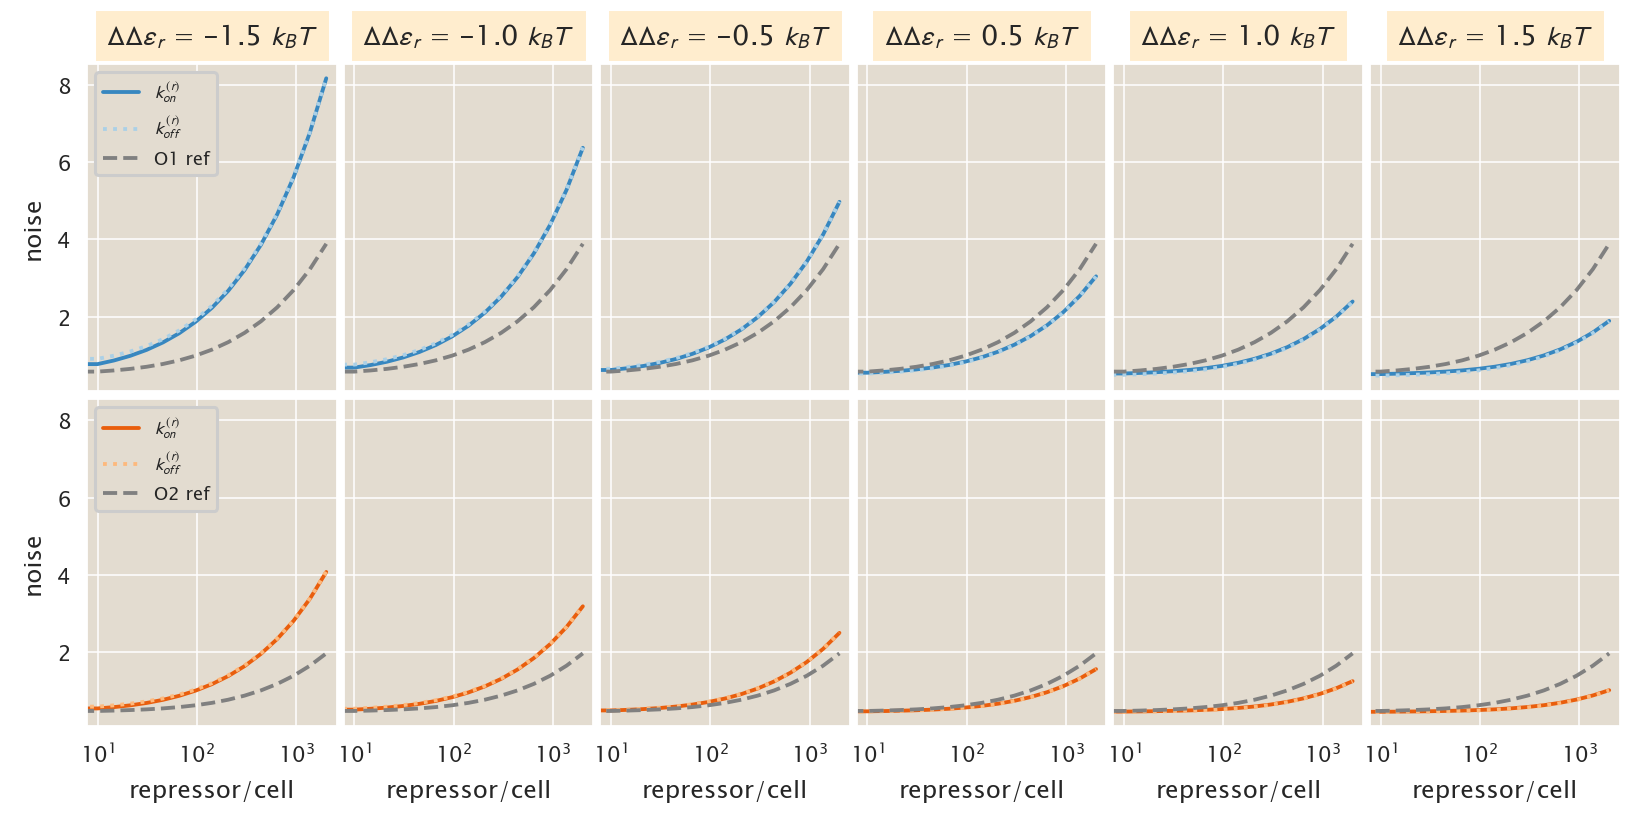

In [64]:
# Extract data with c = 0
df_kroff_c0 = df_kroff[df_kroff.inducer_uM == 0]
df_kron_c0 = df_kron[df_kron.inducer_uM == 0]

# List unique energy offshifts different from zero
offshift = df_kroff.offshift.unique()
offshift_unique = offshift[offshift != 0]

# Define color for operators
# Generate list of colors
col_list = ['Blues_r', 'Oranges_r']

# Initialize plot
fig, ax = plt.subplots(2, 6, figsize=(9, 4),
                       sharex=True, sharey=True)

#kron change
# Group by operator
df_group = df_kron_c0.groupby('operator')

#Loop through operators
for i, (group, op_data) in enumerate(df_group):
    
    # Set operator color
    color = sns.color_palette(col_list[i], n_colors=2)[0]
    
    # Loop through unique offshifts
    for j, o in enumerate(offshift_unique):
        # Extract data
        data = op_data[op_data.offshift == o]
        
        # Compute noise
        noise = np.sqrt(data.m0p2 - data.m0p1**2) / data.m0p1 
        
        # Plot noise in corresponding panel
        ax[i, j].plot(data.repressor, noise, color=color,
                      label='$k_{on}^{(r)}$')
        
        
        
#kron change
# Group by operator
df_group = df_kroff_c0.groupby('operator')

#Loop through operators
for i, (group, op_data) in enumerate(df_group):
    # Extract "wt" data
    wt_data = op_data[(op_data.offshift == 0)]
    
    # Set operator color
    color = sns.color_palette(col_list[i], n_colors=2)[1]
    
    # Loop through unique offshifts
    for j, o in enumerate(offshift_unique):
        # Extract data
        data = op_data[op_data.offshift == o]
        
        # Compute noise
        noise = np.sqrt(data.m0p2 - data.m0p1**2) / data.m0p1 
        # Compute reference noise
        ref_noise = np.sqrt(wt_data.m0p2 - wt_data.m0p1**2) / wt_data.m0p1 
        
        # Plot fold-change in corresponding panel
        ax[i, j].plot(data.repressor, noise, color=color,
                      label='$k_{off}^{(r)}$', linestyle=':')
        # Plot reference fold-change
        ax[i, j].plot(wt_data.repressor, ref_noise, color='gray',
                      linestyle='--', label='{:s} ref'.format(group))
        
        # Adjust plot axis
        ax[i, j].set_xscale('log')
        
        # Add x label to lower plots
        if i==1:
            ax[i, j].set_xlabel('repressor/cell')
        # Add y label to left plots
        if j==0:
            ax[i, j].set_ylabel('noise')
            # Add legend
            ax[i, j].legend(loc='upper left', fontsize=6)
            
            
        # Add offshift top of colums
        if i==0:
            label = r'$\Delta\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(o)
            ax[i, j].set_title(label, bbox=dict(facecolor='#ffedce'))


# Adjust spacing
plt.subplots_adjust(hspace=0.02, wspace=0.02)

Wow... This is shocking. I guess my hypothesis didn't work at all. There is literally no difference between changes in the on and off rates.